# Recurrent Neural Network (GRU)  外汇交易预测
基于 TensorFlow 2.0，GRU，Keras Model() api 实现

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (16, 8)
summary_writer = tf.summary.create_file_writer('E:/Code/play_python/project/tensorboard')

In [38]:
def data_loader():
    data_file="E:/Code/play_python/project/GBPUSD.pro1440.csv"
    raw_data = pd.read_csv(data_file, parse_dates=['Date'])
    return raw_data

In [39]:
# 加载数据
data = data_loader()
data

,Date,Time,Open,High,Low,Close,Volume
0,2012-01-20,00:00,1.54860,1.55770,1.54500,1.55740,79844
1,2012-01-23,00:00,1.55540,1.56010,1.55160,1.55650,82459
2,2012-01-24,00:00,1.55650,1.56250,1.55320,1.56240,76263
3,2012-01-25,00:00,1.56250,1.56780,1.55330,1.56570,84081
4,2012-01-26,00:00,1.56560,1.57330,1.56490,1.56880,77611
...,...,...,...,...,...,...,...
2043,2019-10-30,00:00,1.28682,1.29072,1.28377,1.28966,152018
2044,2019-10-31,00:00,1.28960,1.29756,1.28929,1.29405,167251
2045,2019-11-01,00:00,1.29402,1.29723,1.29239,1.29404,156924
2046,2019-11-04,00:00,1.29171,1.29424,1.28758,1.28814,133989


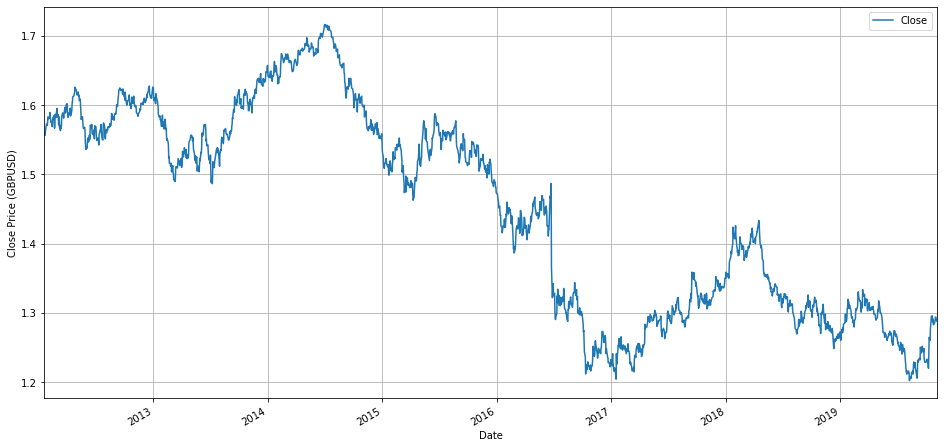

In [40]:
# Plot the Close Price Trend
ax = data.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (GBPUSD)")
plt.grid()

## 数据预处理

### 数据归一化

In [41]:
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = data.Close.values.reshape(-1, 1)
close_data = scaler.fit_transform(close_price)
close_data

array([[0.69052157],
       [0.68877134],
       [0.70024503],
       ...,
       [0.17836724],
       [0.16689355],
       [0.16922718]])

### 定义数据序列化、分批
sequence

In [42]:
def make_sequence(data, seq_len):
    # Make sequence
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + seq_len
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X, np.float32), np.array(y, np.float32)
    
def split_sequence(data, seq_len, train_split):
    X, y = make_sequence(data, seq_len)

    # Split sequence into training data and testing data
    num_train = int(train_split * X.shape[0])
    X_train = X[:num_train]
    y_train = y[:num_train]
    X_test = X[num_train:]
    y_test = y[num_train:]
    return X_train, y_train, X_test, y_test

## 模型定义

In [43]:
class MyGRU(tf.keras.Model):
    def __init__(self, seq_length, n_features):
        super().__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        
        self.GRU1 = tf.keras.layers.GRU(self.seq_length, return_sequences=True, input_shape=(self.seq_length, self.n_features))
        self.GRU2 = tf.keras.layers.GRU(self.seq_length)
        self.dense = tf.keras.layers.Dense(units=1)
    
    def call(self, inputs):
        x = self.GRU1(inputs)
        x = self.GRU2(x)
        output = self.dense(x)
        return output

## 模型训练

### 定义一些超参数

In [44]:
SEQ_LEN = 100
n_features = 1

learning_rate = 0.001
EPOCH = 50
batch_size = 50

### 得到训练数据，测试数据

In [45]:
X_train, y_train, X_test, y_test = split_sequence(close_data, SEQ_LEN, train_split = 0.9)

### 执行训练

In [46]:
gru_net = MyGRU(seq_length=SEQ_LEN, n_features=n_features)
optimizer = tf.optimizers.Adam(learning_rate)

In [47]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(100)

In [48]:
for epoch in range(1, EPOCH + 1):
    for X, y in train_data:
        with tf.GradientTape() as g:
            pred_y = gru_net(X)
            loss = tf.keras.losses.MAE(y, pred_y)
            loss = tf.reduce_mean(loss)
        trainable_variables = gru_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    print("Epoch: %i, loss: %f" % (epoch, loss.numpy()))
    with summary_writer.as_default():                              
        tf.summary.scalar("loss", loss.numpy(), step=epoch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 1, loss: 0.085781
Epoch: 2, loss: 0.016235
Epoch: 3, loss: 0.015620
Epoch: 4, loss: 0.015103
Epoch: 5, loss: 0.017276
Epoch: 6, loss: 0.014160
Epoch: 7, loss: 0.015033
Epoch: 8, loss: 0.014808
Epoch: 9, loss: 0.011472
Epoch: 10, loss: 0.016200
Epoch: 11, loss: 0.014052
Epoch: 12, loss: 0.010897
Epoch: 13, loss: 0.010208
Epoch: 14, loss: 0.018026
Epoch: 15, loss: 0.015292
Epoch: 16, loss: 0.022647
Epoch: 17, loss: 0.012735
Epoch: 18, loss: 0.009934
Epoch: 19, loss: 0.011890
Epoch: 20, loss: 0.0105

## 进行验证

In [49]:
y_hat = gru_net.predict(X_test)
loss = tf.reduce_mean(tf.keras.losses.MAE(y_test, y_hat))
loss.numpy()

0.00970345

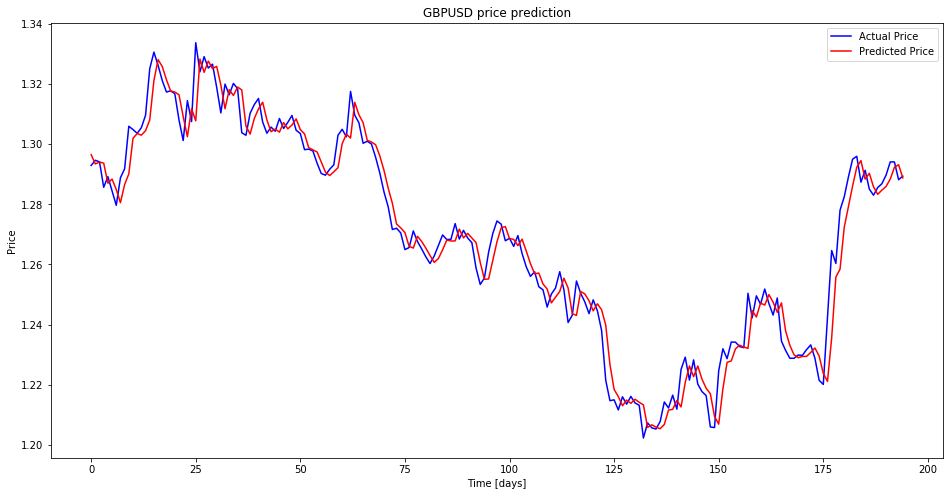

In [50]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
plt.title('GBPUSD price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()